# Simulating coupled Classical Harmonic oscillators using Classiq
___

**Authors**: Viraj Dsouza, Cristina Radian, Kerem Yurtseven

**Date**: 09.08.2024

This work is designed under and for the final project of the Womanium Quantum+AI Program 2024

**Main Reference**: Exponential Quantum Speedup in Simulating Coupled Classical Oscillators, Babbush et.al, 2023 [1](https://arxiv.org/abs/2303.13012)
___

## Theoretical Background:


We are trying to find a solution for a system of classical coupled harmonic oscillators with $N=2^n$ masses. Let $\vec{x}$ be the displacement vector
$$
    \vec{x} = \left(x_1(t),.....,x_N(t) \right)^T \in \mathbb{R}^N
    \qquad (1)
$$
So, for the system of $N$ masses connected by springs, Newton's equation becomes
$$
    m_j \ddot{x}_j(t) = \sum_{k \neq j} \kappa_{jk} \left( x_k(t) - x_j(t) \right) - \kappa_{jj} x_j(t) \qquad (2)
$$
where $j \in [N] := \{1,...,N\}$ and $\kappa_{jk}$ is the spring constant of the spring connecting the $j ^{th}$ and the $k ^{th}$ masses.

Representing Newton's Equation in matrix form:
$$
    \mathbf{M}\ddot{\vec{x}}(t) = - \mathbf{F}\vec{x}(t)
    \qquad (3)
$$
where $\mathbf{M}$ is the $N\times N$ diagonal matrix with entries $m_j > 0$ and $\mathbf{F}$ is an $N\times N$ matrix with $f_{jj}=\sum_k \kappa_{jk}$ and $f_{jk} = -\kappa_{jk}$.

___



In order to reduce Newton's Equation to a Quantum Evolution, we perform a change of variable where $\vec{y}(t) := \sqrt{\mathbf{M}}\vec{x}(t)$. Equation $(3)$ becomes:
$$
    \ddot{\vec{y}}(t) = -\mathbf{A}\vec{y}(t)
    \qquad (4)
$$
where $\mathbf{A} := \sqrt{\mathbf{M}}^{-1}\mathbf{F}\sqrt{\mathbf{M}}^{-1}$. Convert equation (4) into a similar form of Schrödinger's Equation by adding $i\sqrt{\mathbf{A}}\dot{\vec{y}}(t)$ on both sides of equation $4$,
$$
    \ddot{\vec{y}}(t) + i\sqrt{\mathbf{A}}\dot{\vec{y}}(t)=i\sqrt{\mathbf{A}}\left(\dot{\vec{y}}(t) + i\sqrt{\mathbf{A}}\vec{y}(t)\right)
    \qquad (5)
$$
Solution to (5) is
$$
    \dot{\vec{y}}(t) + i\sqrt{\mathbf{A}}\vec{y}(t) = e^{it\sqrt{\mathbf{A}}}\left(\dot{\vec{y}}(0) + i\sqrt{\mathbf{A}}\vec{y}(0)\right)
    \qquad (6)
$$

___

In order to access $\sqrt{\mathbf{A}}$, define $\mathbf{B}\mathbf{B^\dagger} = \mathbf{A}$ where B is $N\times M$ and $M = N\times (N+1) /2$. However, to simulate the Hamiltonian using qubits, we need it to be a square matrix of dimension $2^{q}$ where $q$ is the number of qubits simulating $H$. To achieve this, we  pad $B$ with zeros to make its dimension $N^2\times N^2$, so that $H$ becomes a $2N^{2}X2N^{2}$ matrix which can be simulated with $q=2n+1$ qubits, where $N=2^{n}$. So, the hamiltonian after padding becomes
$$
    \mathbf{H} := -\begin{pmatrix}
\mathbf{0}{_{N^{2}XN^{2}}} & \mathbf{B}{_{N^{2}XN^{2}}}\\
\mathbf{B^\dagger}{_{N^{2}XN^{2}}} & \mathbf{0}{_{N^{2}XN^{2}}}
\end{pmatrix}_{2N^{2}X2N^{2}}
\qquad (7)
$$
(5) can be stated as:
$$
    |{\dot{\psi}(t)}\rangle = -i\mathbf{H} |{\psi(t)}\rangle
    \qquad (8)
$$
where
$$
    |{\psi(t)}\rangle \propto \begin{pmatrix}
\dot{\vec{y}}(t)\\
i\mathbf{B^\dagger}\vec{y}(t)
\end{pmatrix}
\qquad (9)
$$
is an appropriate solution to equation $(8)$

Here $\mathbf{A}$ is positive-semi definite and Hermitian by definition, Cholesky decomposition cannot be used to find $\mathbf{B}$ always since it requires $A$ to be positive definite. A method to find $\mathbf{B}$ is given by the paper
$$
    \sqrt{\mathbf{M}}\mathbf{B}|{j,k}\rangle=
    \begin{cases}
        \sqrt{\kappa_{jj}} & \text{if } j = k\\
        \sqrt{\kappa_{jk}}\left(|{j}\rangle-|{k}\rangle \right) & \text{if } j < k
    \end{cases}
    \qquad (10)
$$
where $|{j,k}\rangle$ is the bra-ket notation for the basis of complex space $\mathbb{C}^{M}$ over $\mathbb{C}$ and $j \leq k \in [N]$.
___

<!-- ##### A brief background on vector spaces:

Here is a crucial point for the difference between basis over $\mathbb{C}$ and basis over $\mathbb{R}$. If basis are given over $\mathbb{C}$, they are the complex combinations of the bases and if bases are given over $\mathbb{R}$, they are the real combinations of the basis vectors. To illustrate, let us take the bases of $\mathbb{C}^2$ and $\gamma \in \mathbb{C}^2$.
$$
    \vec{\gamma} = a_1\begin{pmatrix}
            1\\
            0
            \end{pmatrix} + a_2\begin{pmatrix}
            0\\
            1
            \end{pmatrix} + a_3\begin{pmatrix}
            i\\
            0
            \end{pmatrix} + a_4\begin{pmatrix}
            0\\
            i
            \end{pmatrix}
    \qquad (11)
$$
(11) is the span for $\gamma$ using bases of $\mathbb{C}^2$ over $\mathbb{R}$ and $a_i \in \mathbb{R}$.
$$
    \vec{\gamma} = c_1\begin{pmatrix}
            1\\
            0
            \end{pmatrix} + c_2\begin{pmatrix}
            0\\
            1
            \end{pmatrix}
    \qquad (12)
$$
(12) is the span for  $\gamma$ using bases of $\mathbb{C}^2$ over $\mathbb{C}$ and $c_i \in \mathbb{C}$. -->


In order to create $\mathbf{B}$, use (10).

For $k=j=1$:
$$
\sqrt{\mathbf{M}}\mathbf{B}|{1,1}\rangle = \sqrt{\kappa_{11}}|{1}\rangle

$$

$$
\mathbf{B}|{1,1}\rangle = \begin{pmatrix}
    0 \\
    0
\end{pmatrix} 
$$

$$
\mathbf{B}\begin{pmatrix}
    1 \\
    0 \\
    0
\end{pmatrix} = \begin{pmatrix}
    0 \\
    0
\end{pmatrix} \qquad (15)
$$

For $k=1$ and $j=2$:
$$
\sqrt{\mathbf{M}}\mathbf{B}|{1,2}\rangle = \sqrt{\kappa_{12}}\left( |{1}\rangle - |{2} \rangle \right) 
$$

$$
\mathbf{B}|{1,2}\rangle = \left( |{1}\rangle - |{2} \rangle \right) 
$$

$$
\mathbf{B} \begin{pmatrix}
    0 \\
    1 \\
    0
\end{pmatrix} = \begin{pmatrix}
    1 \\
    0
\end{pmatrix} - \begin{pmatrix}
    0 \\
    1
\end{pmatrix} 
$$

$$
\mathbf{B} \begin{pmatrix}
    0 \\
    1 \\
    0
\end{pmatrix} = \begin{pmatrix}
    1 \\
    -1
\end{pmatrix} \qquad (16)
$$

For $k=j=2$:
$$
\sqrt{\mathbf{M}}\mathbf{B}|{2,2}\rangle = \sqrt{\kappa_{22}}|{2} \rangle 
$$

$$
\mathbf{B}|{2,2}\rangle = \begin{pmatrix}
    0 \\
    0
\end{pmatrix} 
$$

$$
\mathbf{B} \begin{pmatrix}
    0 \\
    0 \\
    1
\end{pmatrix} = \begin{pmatrix}
    0 \\
    0
\end{pmatrix} \qquad (17)
$$
Combining $(15), (16), (17)$
$$
\mathbf{B}\begin{pmatrix}
    1 & 0 & 0 \\
    0 & 1 & 0 \\
    0 & 0 & 1
\end{pmatrix} = \begin{pmatrix}
    0 & 1 & 0 \\
    0 & -1 & 0
\end{pmatrix} 
$$

$$
\mathbf{B} = \begin{pmatrix}
    0 & 1 & 0 \\
    0 & -1 & 0
\end{pmatrix} \qquad (18)
$$

Lastly, show that $\mathbf{B}\mathbf{B}^\dagger = \mathbf{A}$
$$
\begin{pmatrix}
    0 & 1 & 0 \\
    0 & -1 & 0
\end{pmatrix} \begin{pmatrix}
    0 & 0 \\
    1 & -1 \\
    0 & 0
\end{pmatrix} = \begin{pmatrix}
    1 & -1 \\
    -1 & 1
\end{pmatrix} \qquad (19)
$$
That ends the constitution of $\mathbf{B}$ for this example.

Following equation $(7)$ the Hamiltonian ($H$) for this case becomes
$$
\mathbf{H} = \begin{pmatrix}
    0 & 0 & 0 & 0 & 0 & 1 & 0 & 0 \\
    0 & 0 & 0 & 0 & 0 & -1 & 0 & 0 \\
    0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
    0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
    0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
    1 & -1 & 0 & 0 & 0 & 0 & 0 & 0 \\
    0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
    0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 \\
\end{pmatrix} \qquad (20)
$$

___

We can also use the following methodology (for the simplest case) to obtain $B$ from $A$.

For a square and **normal** matrix $A$ we have the eigen value decomposition as follows: 

$$
A = V \Lambda V^T
$$

where:
    $V$ is the matrix of eigenvectors of $A$.
    $\Lambda$ is the diagonal matrix of eigenvalues of $A$.


Next, we construct the diagonal matrix $\sqrt{\Lambda}$ containing the square roots of the eigenvalues:

$$
\sqrt{\Lambda} = \text{diag}(\sqrt{\lambda_1}, \sqrt{\lambda_2}, \ldots, \sqrt{\lambda_n})
$$

We then define the matrix $B$ as follows:

$$B = V \sqrt{\Lambda}$$


Its easy to verify that $A$ can be reconstructed from $B$ as $ A= BB^T$

___


## Simulating the simplest Possible case:

In [2]:
## Import Libraries
import numpy as np
import matplotlib.pyplot as plt
import qutip as qt
import typing
import itertools
import scipy
from classiq import *
from classiq.execution import ExecutionPreferences, ClassiqBackendPreferences, ClassiqSimulatorBackendNames
from typing import cast
from qutip import qeye, sigmax, sigmay, sigmaz
from itertools import product
from numpy import kron
from scipy.special import eval_chebyt, jv
from classiq.qmod.symbolic import pi

## Defining all Global Variables
PAULI_DICT = {
    "I": np.array([[1, 0], [0, 1]], dtype=np.complex128),
    "Z": np.array([[1, 0], [0, -1]], dtype=np.complex128),
    "X": np.array([[0, 1], [1, 0]], dtype=np.complex128),
    "Y": np.array([[0, -1j], [1j, 0]], dtype=np.complex128),
}

CHAR_TO_STUCT_DICT = {"I": Pauli.I, "X": Pauli.X, "Y": Pauli.Y, "Z": Pauli.Z}

### Function Declarations for Pre-processing classical inputs for loading as quantum inputs:

In [3]:
def initialize_system():

    N = int(input("Enter the number of masses (N): "))

    # Initialize the mass matrix (M) and spring constant matrix (K)
    M = np.zeros((N, N))
    K = np.zeros((N, N))

    # Input the values of the masses
    for i in range(N):
        M[i, i] = float(input(f"Enter the mass m_{i+1}: "))

    # Input the spring constants
    for i in range(N):
        for j in range(i, N):
            k = float(input(f"Enter the spring constant k_{i+1}{j+1}: "))
            K[i, j] = k
            K[j, i] = k  # Since K is a symmetric matrix

    # Input the initial position vector (x_0)
    x_0 = np.zeros((N, 1))
    for i in range(N):
        x_0[i, 0] = float(input(f"Enter the initial position x_0_{i+1}: "))

    # Input the initial velocity vector (xdot_0)
    xdot_0 = np.zeros((N, 1))
    for i in range(N):
        xdot_0[i, 0] = float(input(f"Enter the initial velocity xdot_0_{i+1}: "))

    return N, M, K, x_0, xdot_0


def create_matrix_F(K, N):
    """
        Definition:
            Compose the F matrix using the spring coefficients
        Args:
            K (nd_array NxN): Spring Coefficients - Symmetric Matrix
            N (int): Number of masses - should be 2^n
        Outputs:
            F (nd_array NxN): F matrix 
    """

    F = np.zeros((N,N))

    for i in range(N):
        for j in range(N):
            if i == j: # Sum of kappa_{ik} over all k in 1 to N
                tmp = 0
                for l in range(N):
                    tmp += K[i][l]
                F[i][i] = tmp
            if i != j: # -kappa_{ij}
                F[i][j] = -K[i][j]
    
    return F
            
def create_matrix_A(M, F):
    """
        Definition:
            Compose the A matrix using F matrix and mass matrix M
        Args:
            M (nd_array NxN): Mass Matrix - Diagonal Matrix
            F (nd_array NxN): F matrix - Symmetric Matrix
        Outputs:
            A (nd_array NxN): A matrix - PSD and Real Symmetric
    """

    rootM = np.sqrt(M)
    rootM_inverse = np.linalg.inv(rootM)

    A = np.linalg.multi_dot([rootM_inverse, F, rootM_inverse])

    return A

def coordinate_transformation(M, x_0, xdot_0):
    """
        Definition:
            Transform x coordinates to y coordinates
        Args:
            M (nd_array NxN): Mass Matrix - Diagonal Matrix
            x_0 (nd_array 1xN): Initial Positions
            xdot_0 (nd_array 1xN): Initial Velocities
        Outputs:
            Y (dict): Dictionary containing transformed coordinates    
                y_0 (nd_array 1xN): Transformed Positions
                ydot_0 (nd_array 1xN): Transformed Velocities        
    """

    y_0 = np.matmul(np.sqrt(M), x_0)
    ydot_0 = np.matmul(np.sqrt(M), xdot_0)

    Y = {"y_0": y_0, "ydot_0": ydot_0}

    return Y

def create_matrix_B(M, K, A, N):
    """
        Definition:
            Compose B matrix using eq.16
        Args:
            M (nd_array NxN): Mass Matrix - Diagonal Matrix
            K (nd_array NxN): Spring Coefficients - Symmetric Matrix
            A (nd_array NxN): A matrix - PSD and Real Symmetric
            N (int): Number of masses - should be 2^n
        Outputs:
            B (nd_array NxM): B Matrix - M = N * (N + 1) / 2
    """

    B = np.zeros((N,int(N*(N+1)/2)))
    
    rootM = np.sqrt(M)
    rootM_inverse = np.linalg.inv(rootM)

    for i in range(N):
        for j in range(i,N):
            tmp = np.zeros((N,1))
            
            if i == j:
                bra = np.zeros((N,1))
                bra[i][0] = 1
                tmp = np.sqrt(K[i][j]) * bra
            
            if i != j:
                bra0 = np.zeros((N,1))
                bra1 = np.zeros((N,1))
                bra0[i][0] = 1
                bra1[j][0] = 1
                tmp = np.sqrt(K[i][j]) * (bra0 - bra1)

            tmpcol = np.matmul(rootM_inverse, tmp)

            for l in range(N):
                B[l][i+j] = tmpcol[l][0]

    return B 
    
def padding_B(B, N):
    """
        Definition:
            Pad B with zeros to make it a square matrix
        Args:
            B (nd_array NxM): B Matrix - M = N * (N + 1) / 2
            N (int): Number of masses - should be 2^n
        Outputs:
            B_padded (nd_array N^2xN^2): Padded B Matrix
    """
    
    B_padded = np.zeros((int(N**2), int(N**2)))
    B_padded[:N, :int(N*(N+1)/2)] = B

    return B_padded

def create_Hamiltonian(B):
    """
        Definition:
            Compose Hamiltonian Matrix eq.12
        Args:
            B (nd_array N^2xN^2): Padded B Matrix
        Outputs:
            H (nd_array 2*N^2x2*N^2): Padded Hamiltonian - Hermitian Matrix
    """

    H = -np.block([[np.zeros((B.shape[0], B.shape[0])), B], [B.conj().T, np.zeros((B.shape[1], B.shape[1]))]])

    return H

def create_init_state(B, y_0, ydot_0, N):
    """
        Definition:
            Create the initial state eq.14
        Args:
            B (nd_array N^2xN^2): Padded B Matrix
            y_0 (nd_array 1xN): Transformed Positions
            ydot_0 (nd_array 1xN): Transformed Velocities 
        Outputs:
            init_state (nd_array 1x2*N^2): Initial State to be using Hamiltonian Evolution  
    """

    y_0_padded = np.pad(y_0, ((0, N**2-N), (0, 0)), mode='constant', constant_values=0)
    init_lower = 1j * np.matmul(B.T, y_0_padded)
    ydot_0_padded = np.pad(ydot_0, ((0, N**2-N), (0, 0)), mode='constant', constant_values=0)

    init_state = np.vstack((ydot_0_padded, init_lower.reshape(-1, 1)))

    return init_state

def normalize_init_state(init_state):
    """
        Definition:
            Normalize the initial state
        Args:
            init_state (nd_array 1x2*N^2): Initial State to be using Hamiltonian Evolution  

        Outputs:
            normalization (dict): Dictionary containing normalized initial state and normalization factor
                norm (int): Normalization factor
                normalized_init_state (1D list 2*N^2): Normalized Initial State with Real Amplitudes (add pi/2 phase in evolution)
    """

    amp = 0
    for i, element in enumerate(init_state):
        amp += element * element.conj()

    norm = np.sqrt(amp)
    init_state_normalized_complex = init_state / norm

    half_index = int(len(init_state_normalized_complex) / 2)
    normalized_init_state = init_state_normalized_complex
    normalized_init_state[half_index:, 0] = -1j * init_state_normalized_complex[half_index:, 0]

    return {"norm": norm, "normalized_init_state": normalized_init_state[:,0]}

#### Pre-Processing of simple case $1$ for quantum evolution:

- Create B Matrix, Hamiltonian and initial state

In [5]:
N, M, K, x_0, xdot_0 = initialize_system() # plug N=2 for 2 case system 

# F Matrix
F= create_matrix_F(K, N)

# A Matrix
A = create_matrix_A(M, F)

# Transform coordinates
y = coordinate_transformation(M, x_0, xdot_0)
y_0 = y["y_0"]
ydot_0 = y["ydot_0"]

# B Matrix
B = create_matrix_B(M, K, A, N)

# Stacking B with zeros to get square matrix N^2 x N^2
B_padded = padding_B(B, N)

# Hamiltonian
H = create_Hamiltonian(B_padded)

# Initial State
init_state = create_init_state(B_padded, y_0, ydot_0, N)

# Normalize the Initial State
normalization = normalize_init_state(init_state)
normalized_init_state = normalization["normalized_init_state"]
norm = normalization["norm"]

# Print the results
print("B matrix:", B)
print("Hamiltonian formed:", H)
print("Initial State:", init_state)

assert np.matmul(B, B.conj().T).all()==A.all()

B matrix: [[ 2.          2.44948974  0.        ]
 [ 0.         -2.44948974  2.        ]]
Hamiltonian formed: [[-0.         -0.         -0.         -0.         -2.         -2.44948974
  -0.         -0.        ]
 [-0.         -0.         -0.         -0.         -0.          2.44948974
  -2.         -0.        ]
 [-0.         -0.         -0.         -0.         -0.         -0.
  -0.         -0.        ]
 [-0.         -0.         -0.         -0.         -0.         -0.
  -0.         -0.        ]
 [-2.         -0.         -0.         -0.         -0.         -0.
  -0.         -0.        ]
 [-2.44948974  2.44948974 -0.         -0.         -0.         -0.
  -0.         -0.        ]
 [-0.         -2.         -0.         -0.         -0.         -0.
  -0.         -0.        ]
 [-0.         -0.         -0.         -0.         -0.         -0.
  -0.         -0.        ]]
Initial State: [[ 0.70710678+0.j        ]
 [ 0.70710678+0.j        ]
 [ 0.        +0.j        ]
 [ 0.        +0.j        ]
 [ 0.  

- Finding the Pauli decomposition of the Hamiltonian formed above:

(Below functions for Pauli Decomposition is taken from [Classiq Library](https://github.com/Classiq/classiq-library/blob/main/algorithms/hhl/hhl/hhl.ipynb), thanks a lot to the authors!)

In [6]:
def generate_all_pauli_strings(paulis, n):
    """
        Definition:
            Create all combination of Pauli Matrices for n qubits
        Args:
            paulis (string): Name of the Pauli Matrices
            n (int): log2(2*N^2) where N is the number of masses
        Outputs:
            pauli_comb (list of strings): All combination of Pauli Matrices
    """    
    for s in itertools.product(paulis, repeat=n):
        yield "".join(s)

def pauli_string_2mat(seq):
    """
        Definition:
            Transform a Pauli Matrix Sequence to a single Matrix
        Args:
            seq (string): Name of the Pauli Matrices as a sequence
        Outputs:
            pauli_mat (nd_array): Multipication of Pauli Matrices
    """ 
    pauli_mat = PAULI_DICT[seq[0]]
    for p in seq[1:]:
        pauli_mat = np.kron(pauli_mat, PAULI_DICT[p])
    return pauli_mat

def hilbert_schmidt(M1, M2):
    """
        Definition:
            Hilbert-Schmidt Product of two matrices
        Args:
            M1 (nd_array): Matrix 1
            M2 (nd_array): Matrix 2
        Outputs:
            (nd_array): Product result
    """ 
    return (np.dot(M1.conjugate().transpose(), M2)).trace()

def lcu_naive(H):
    """
        Definition:
            Create the Pauli-Matrix-Decomposition of Hamiltonian
        Args:
            H (nd_array 2*N^2x2*N^2): Padded Hamiltonian - Hermitian Matrix
        Outputs:
            pauli_list (list): Each Pauli Matrix sequence with non-zero coefficient
    """

    assert H.shape[0] == H.shape[1], "Matrix is not square"
    assert H.shape[0] != 0, "Matrix is of size 0"
    assert H.shape[0] & (H.shape[0] - 1) == 0, "Matrix size is not 2**n"

    n = int(np.log2(H.shape[0]))
    possible_pauli_list = list(generate_all_pauli_strings("IZXY", n))

    pauli_list = []

    for pstr in possible_pauli_list:
        co = (1 / 2**n) * hilbert_schmidt(pauli_string_2mat(pstr), H)
        if co != 0:
            pauli_list = pauli_list + [(pstr, co)]

    return pauli_list

def pauli_str_to_enums(pauli):
    """
        Definition:
            Create Classiq Pauli matrices for Pauli Matrix Sequence
        Args:
            pauli (string): Pauli Matrix Sequence String
        Outputs:
            (list): Classiq Pauli Matrices
    """
    return [CHAR_TO_STUCT_DICT[s] for s in pauli]

def pauli_list_to_hamiltonian(pauli_list):
    """
        Definition:
            Create complete Pauli list for a given Hamiltonian
        Args:
            pauli_list (list): Each Pauli Matrix sequence with non-zero coefficient
        Outputs:
            (list): Classiq PauliTerm function with appropriate Pauli matrices
    """
    return [
        PauliTerm(
            pauli=pauli_str_to_enums(pauli), coefficient=typing.cast(complex, coeff).real
        )
        for pauli, coeff in pauli_list
    ]

In [12]:
# Create the Pauli Matrix Decomposition of the Hamiltonian
pauli_list = lcu_naive(H)

# Transform Pauli Matrix Decomposition to Classiq compatible
classiq_pauli_list = pauli_list_to_hamiltonian(pauli_list)

print(pauli_list)

[('XII', (0.11237243569579447+0j)), ('XIZ', (-1.1123724356957945+0j)), ('XIX', (-0.6123724356957945+0j)), ('XZI', (0.11237243569579447+0j)), ('XZZ', (-1.1123724356957945+0j)), ('XZX', (-0.6123724356957945+0j)), ('XXX', (-0.5+0j)), ('XYY', (-0.5+0j)), ('YIY', (0.6123724356957945+0j)), ('YZY', (0.6123724356957945+0j)), ('YXY', (-0.5+0j)), ('YYX', (0.5+0j))]


[PauliTerm(pauli=[<Pauli.X: 1>, <Pauli.I: 0>, <Pauli.I: 0>], coefficient=0.11237243569579447),
 PauliTerm(pauli=[<Pauli.X: 1>, <Pauli.I: 0>, <Pauli.Z: 3>], coefficient=-1.1123724356957945),
 PauliTerm(pauli=[<Pauli.X: 1>, <Pauli.I: 0>, <Pauli.X: 1>], coefficient=-0.6123724356957945),
 PauliTerm(pauli=[<Pauli.X: 1>, <Pauli.Z: 3>, <Pauli.I: 0>], coefficient=0.11237243569579447),
 PauliTerm(pauli=[<Pauli.X: 1>, <Pauli.Z: 3>, <Pauli.Z: 3>], coefficient=-1.1123724356957945),
 PauliTerm(pauli=[<Pauli.X: 1>, <Pauli.Z: 3>, <Pauli.X: 1>], coefficient=-0.6123724356957945),
 PauliTerm(pauli=[<Pauli.X: 1>, <Pauli.X: 1>, <Pauli.X: 1>], coefficient=-0.5),
 PauliTerm(pauli=[<Pauli.X: 1>, <Pauli.Y: 2>, <Pauli.Y: 2>], coefficient=-0.5),
 PauliTerm(pauli=[<Pauli.Y: 2>, <Pauli.I: 0>, <Pauli.Y: 2>], coefficient=0.6123724356957945),
 PauliTerm(pauli=[<Pauli.Y: 2>, <Pauli.Z: 3>, <Pauli.Y: 2>], coefficient=0.6123724356957945),
 PauliTerm(pauli=[<Pauli.Y: 2>, <Pauli.X: 1>, <Pauli.Y: 2>], coefficient=-0.5),
 P

In [13]:
# check if the decomposition is correct, we use qutip for this

# Define the Pauli matrices and the identity matrix
pauli_operators = {
    'I': qt.qeye(2),
    'X': qt.sigmax(),
    'Y': qt.sigmay(),
    'Z': qt.sigmaz()
}

def create_hamiltonian(hamiltonian_list):
    hamiltonian = 0
    num_qubits = len(hamiltonian_list[0][0])  

    for term in hamiltonian_list:
        pauli_string, coefficient = term
        
        # calculating tensor products
        term_operator = pauli_operators[pauli_string[0]]
        
        
        for pauli in pauli_string[1:]:
            term_operator = qt.tensor(term_operator, pauli_operators[pauli])
        
        # Adding the terms of the Hamiltonian
        hamiltonian += coefficient * term_operator

    return hamiltonian

hamiltonian = create_hamiltonian(pauli_list)

print(hamiltonian)



Quantum object: dims=[[2, 2, 2], [2, 2, 2]], shape=(8, 8), type='oper', dtype=CSR, isherm=True
Qobj data =
[[ 0.          0.          0.          0.         -2.         -2.44948974
   0.          0.        ]
 [ 0.          0.          0.          0.          0.          2.44948974
  -2.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.        ]
 [-2.          0.          0.          0.          0.          0.
   0.          0.        ]
 [-2.44948974  2.44948974  0.          0.          0.          0.
   0.          0.        ]
 [ 0.         -2.          0.          0.          0.          0.
   0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.          0.        ]]


Thus as we see, the decomposition is exact.

### Hamiltonian simulation

We use the `exponentiation_with_depth_constraint` function of classiq that produces a quantum gate that approximates $e^{iHt}$, for any input **Hermitian operator** $H$ . Since the Hamiltonian for this algorithm is Hermitian by definition, exponentian method can be used straightforwardly. The Classiq engine automatically generates an efficient higher-order Trotter-Suzuki quantum program that minimizes the functional error and satisfies a given local constraint on the depth. 

In [14]:
### Define function for Quantum Algorithm

@qfunc
def init_state_phase(state: QNum):
    """
        Definition:
            Imply -pi/2 phase to the last half (msb qubit) of the QNum state in order to add -i factor
        Args:
            state (QNum): Initial state with bare amplitudes
        Outputs:
            state (QNum): Initial state with phase
    """

    state_in_qubit = QArray("state_in_qubit")
    msb = QArray("msb", QBit)
    
    size = np.log2(init_state.size)
    allocate(size, msb)

    bind(state, state_in_qubit)
    repeat(state_in_qubit.len, lambda i: CX(state_in_qubit[i], msb[i]))
    control(msb[size-1], lambda: PHASE(-np.pi/2, state_in_qubit[size-1]))
    bind(state_in_qubit, state)


@qfunc
def main(state: Output[QNum]):
    """
        Definition:
            Main function to make evolution

        Outputs:
            state (Output[QNum]): Resulting state at the t = evolution_coefficient
    """
        
    prepare_amplitudes(amplitudes=list(normalized_init_state), out=state, bound=0.01)
    init_state_phase(state)

    exponentiation_with_depth_constraint(
        classiq_pauli_list,
        evolution_coefficient=0.05,
        max_depth=1000,
        qbv=state)

In [15]:
# Synthesize the Quantum Algorithm with state vector simulation since phase is important
qmod = create_model(main)
backend_preferences = ClassiqBackendPreferences(backend_name="simulator_statevector")
model_pref = set_execution_preferences(qmod, ExecutionPreferences(num_shots=1, backend_preferences=backend_preferences))
qprog = synthesize(model_pref)
#show(qprog)

In [16]:
# Execute the program and get parsed results
job = execute(qprog)
parsed_state_vector= job.result()[0].value.parsed_state_vector  # to get the phases
parsed_state_vector


[SimulatedState(state={'state': 6.0}, bitstring='110110', amplitude=(0.4429954784445923-0.6078613909009292j)),
 SimulatedState(state={'state': 5.0}, bitstring='101101', amplitude=(-0.26856259953804357+0.368511290165645j)),
 SimulatedState(state={'state': 4.0}, bitstring='100100', amplitude=(0.22149774512448345-0.30393070354921j)),
 SimulatedState(state={'state': 1.0}, bitstring='001001', amplitude=(0.15082372264079755+0.10991687936131192j)),
 SimulatedState(state={'state': 0.0}, bitstring='000000', amplitude=(0.15082369374640262+0.10991685830374105j)),
 SimulatedState(state={'state': 1.0}, bitstring='110001', amplitude=(0.060836516234375006+0.04433626155496592j)),
 SimulatedState(state={'state': 0.0}, bitstring='101000', amplitude=(-0.04551368660206495-0.03316933378870328j)),
 SimulatedState(state={'state': 1.0}, bitstring='101001', amplitude=(0.04551302934706447+0.03316885479629367j)),
 SimulatedState(state={'state': 0.0}, bitstring='100000', amplitude=(0.030418176125767457+0.02216807

### Post-Processing

- We obtain the final velocity and position vectors
- We make a comparison between classical and quantum results

In [17]:
def sum_amplitudes_by_state(simulated_states):
    """
        Definition:
            Sum all the states that corresponds to same output qnum
        Args:
            simulated_states (list): Contains the state vector simulation results
        Output:
            state_amplitude_sums (dict): Amplitude and phase of each output qnum
    """
    state_amplitude_sums = {state: 0 for state in range(len(init_state))}
    
    for sim_state in simulated_states:
        state_value = sim_state.state['state']
        if state_value in state_amplitude_sums:
            state_amplitude_sums[state_value] += sim_state.amplitude
    
    return state_amplitude_sums

def normalize_final_state(state_amplitudes, parsed_state_vector):
    """
        Definition:
            Normalize the final state
        Args:
            state_amplitude_sums (dict): Amplitude and phase of each output qnum
            parsed_state_vector (dict): Results of the state vector simulation
        Output:
            final_state (nd_array 2*N^2x1): Normalized final state taking phases into account
    """

    values = np.array([state_amplitudes[i] for i in range(len(state_amplitudes))])
    global_phase = np.angle(values)[0]
    values = values / np.exp(1j * global_phase)

    normalization = np.linalg.norm(
            [
                parsed_state.amplitude
                for parsed_state in parsed_state_vector
            ]
        )

    final_state = values / normalization

    return final_state


def simplify_final_state(final_state):
    """
        Definition:
            Normalize the final state
        Args:
            final_state (nd_array 2*N^2x1): Normalized final state taking phases into account
        Output:
            simplified_final_state (nd_array 2*N^2x1): Final state with rounding
    """
    
    epsilon = 10**(-4)

    simplified_final_state = final_state
    for i, value in enumerate(final_state):
        imag = np.imag(value)
        real = np.real(value)
        
        if abs(np.real(value)) < epsilon:
            real = 0
        if abs(np.imag(value)) < epsilon:
            imag = 0
        simplified_final_state[i] = real + 1j*imag

    return simplified_final_state

def post_process_final_state(final_state, B, N, c):
    """
        Definition:
            Find the final position and velocity vectors
        Args:
            final_state (nd_array 1x2*N^2): Normalized final state taking phases into account
            B (nd_array N^2xN^2): Padded B Matrix
            N (int): Number of masses - should be 2^n
            c (float): Coefficient to choose position vector from solution space
        Output:
            results (dict): Dictionary containing final position and velocity vectors
    """

    ydot_final = final_state[:N]

    last_half = final_state[N**2:]
    y_final_0_padded = np.linalg.lstsq(B.T,-1j*last_half, rcond= None)[0]

    U, S, Vt = np.linalg.svd(B.T)
    rank = np.sum(S > 1e-10)
    null_space = Vt[rank:].T
    null_space_reduced = null_space[:, -1]
    null_space_reduced = null_space_reduced[..., None]

    y_final = c * null_space_reduced[:N] + y_final_0_padded[:N]

    return {"y_final": y_final, "ydot_final": ydot_final}

def calculate_error(y_quantum, ydot_quantum, y_classic, ydot_classic, N):
    """
        Definition:
            Compare the signs and amplitudes of the final solutions
        Args:
            y_quantum (array Nx1): Final positions taken from quantum solution
            ydot_quantum (array Nx1): Final velocities taken from quantum solution
            y_classical (1D list N): Final positions taken from classical solution
            ydot_classical (1D list N): Final velocities taken from classical solution
            N (int): Number of masses - should be 2^n
        Output:
            (dict): Dictionary containing sign errors and amplitude errors
                errors (dict): Error percent for each value
                sign_check (dict): Sign check for each value
    """

    errors = {}
    sign_check = {}

    for i in range(1, N+1):
        errors.update({f"Position of Mass {i}": 0})
        errors.update({f"Velocity of Mass {i}": 0})
        sign_check.update({f"Position of Mass {i}": "-"})
        sign_check.update({f"Velocity of Mass {i}": "-"})

    for i in range(N):
        errors[f"Position of Mass {i + 1}"] = (abs(abs(y_quantum[i]) - abs(y_classic[i])) / abs(y_classic[i]) * 100)[0]
        errors[f"Velocity of Mass {i + 1}"] = (abs(abs(ydot_quantum[i]) - abs(ydot_classic[i])) / abs(ydot_classic[i]) * 100)[0]

        if np.sign(y_quantum[i]) == np.sign(y_classic[i]):
            sign_check[f"Position of Mass {i+1}"] = "+"
        if np.sign(ydot_quantum[i]) == np.sign(ydot_classic[i]):
            sign_check[f"Velocity of Mass {i+1}"] = "+"

    return {"amplitude_error": errors, "sign_error": sign_check}

In [18]:
# Find the meausurement results of state in a dictionary format
state_amplitudes = sum_amplitudes_by_state(parsed_state_vector)
state_amplitudes

{0: (0.13702115943310506+0.099857886993189j),
 1: (0.2583903175577354+0.18830895343145576j),
 2: (6.425221401388519e-07+4.6825544126341493e-07j),
 3: (7.40357657856256e-07+5.395557337092961e-07j),
 4: (0.2120470861728493-0.2909628721044236j),
 5: (-0.26720416282515613+0.3666472954525505j),
 6: (0.4302182858228886-0.5903290176448657j),
 7: (-7.15162016670489e-08+9.8131788535676e-08j)}

In [19]:
# Normalize the final state
normalized_final_state = normalize_final_state(state_amplitudes, parsed_state_vector)
normalized_final_state

# Simplify the final state by neglecting small terms
simplified_final_state = simplify_final_state(normalized_final_state)
simplified_final_state

# Correct the normalization factor that comes from the normalization of initial state and transform the row vector to column vector
final_state = norm * simplified_final_state[..., None]
print("The final quantum state from quantum evolution", final_state)



The final quantum state from quantum evolution [[0.63438911+0.j        ]
 [1.1963116 +0.j        ]
 [0.        +0.j        ]
 [0.        +0.j        ]
 [0.        -1.34711805j]
 [0.        +1.69752651j]
 [0.        -2.7331421j ]
 [0.        +0.j        ]]


In [20]:
H_qutip = qt.Qobj(H)
rho0 = qt.Qobj(init_state)
tlist = np.linspace(0,0.05,100)
results1 = qt.mesolve(H_qutip,rho0, tlist,[],[])
results1.states[-1]

Quantum object: dims=[[8], [1]], shape=(8, 1), type='ket', dtype=Dense
Qobj data =
[[0.77275626+0.j        ]
 [0.21083492+0.j        ]
 [0.        +0.j        ]
 [0.        +0.j        ]
 [0.        +1.48830324j]
 [0.        -1.69752627j]
 [0.        +2.87432764j]
 [0.        +0.j        ]]

In [21]:
# Get the final position and velocity vectors
final_results = post_process_final_state(final_state, B_padded, N, 0.5/0.707)
y_final = final_results["y_final"]
ydot_final = final_results["ydot_final"]

print("Final Positions", y_final)
print("Final Velocities", ydot_final)

Final Positions [[-0.67355892+0.j]
 [-1.36657115+0.j]]
Final Velocities [[0.63438911+0.j]
 [1.1963116 +0.j]]


### Classical Numerical Solution:

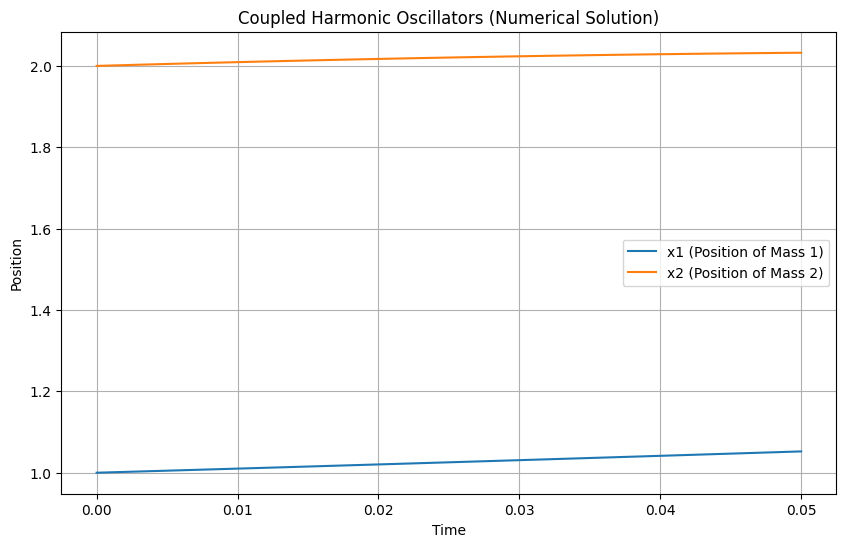

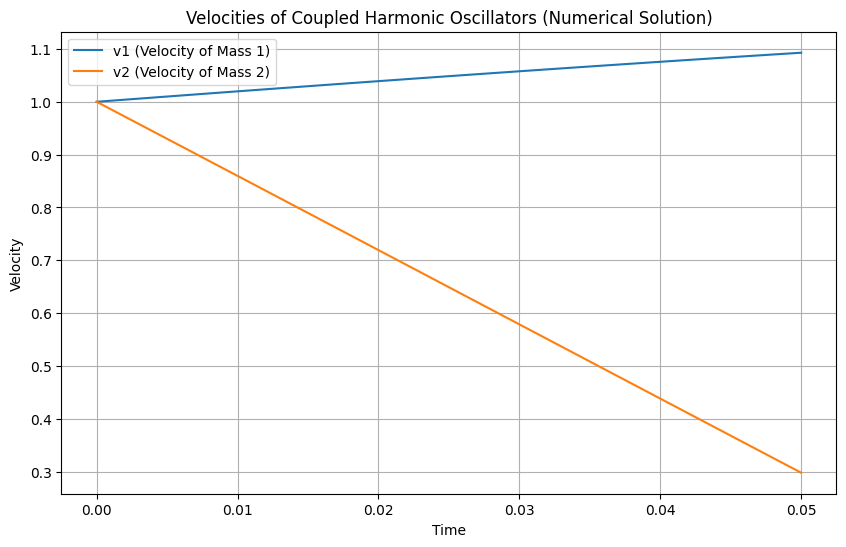

Position Vectors at t=0.05 classically
[1.05238968 2.03245624]
Velocity Vectors at t=0.05 classically
[1.09284258 0.29816525]


In [22]:
def equations_of_motion(t, init, N, M, K):
    """
    Definition:
        EOM for classical coupled oscillator system with N masses
    Args:
        t (array): Time array
        init (list): Initial Conditions
        N (int): Number of masses
        M (array): Mass matrix (diagonal)
        K (array): Spring constant matrix
    Output:
        (list): List of final equations
    """
    x = init[:N]
    v = init[N:]
    dxdt = v
    dvdt = np.zeros(N)
    
    for i in range(N):
        if i == 0:
            dvdt[i] = (-K[i, i] * x[i] + K[i, i+1] * (x[i+1] - x[i])) / M[i, i]
        elif i == N-1:
            dvdt[i] = (-K[i, i] * x[i] + K[i, i-1] * (x[i-1] - x[i])) / M[i, i]
        else:
            dvdt[i] = (-K[i, i] * x[i] + K[i, i-1] * (x[i-1] - x[i]) + K[i, i+1] * (x[i+1] - x[i])) / M[i, i]

    return np.concatenate((dxdt, dvdt))


# Initial conditions: [x1(0), x2(0), ..., xN(0), v1(0), v2(0), ..., vN(0)]
initial_conditions = np.concatenate((x_0, xdot_0))


# Time span for the simulation
t_span = (0, 0.05)
t_eval = np.linspace(t_span[0], t_span[1], 100)

# Solve the system of differential equations
solution = scipy.integrate.solve_ivp(equations_of_motion, t_span, initial_conditions.flatten(), t_eval=t_eval, args=(N, M, K))

# Extract the results
t = solution.t
x = solution.y[:N, :]
v = solution.y[N:, :]


# Plot position results
plt.figure(figsize=(10, 6))
for i in range(N):
    plt.plot(t, x[i], label=f'x{i+1} (Position of Mass {i+1})')
plt.xlabel('Time')
plt.ylabel('Position')
plt.legend()
plt.title('Coupled Harmonic Oscillators (Numerical Solution)')
plt.grid()
plt.show()

# Plot velocity results
plt.figure(figsize=(10, 6))
for i in range(N):
    plt.plot(t, v[i], label=f'v{i+1} (Velocity of Mass {i+1})')
plt.xlabel('Time')
plt.ylabel('Velocity')
plt.legend()
plt.title('Velocities of Coupled Harmonic Oscillators (Numerical Solution)')
plt.grid()
plt.show()


# Get the results numerically
x_classic =np.array([x[0][-1], x[1][-1]])
xdot_classic =np.array([v[0][-1], v[1][-1]])

print("Position Vectors at t=0.05 classically")
print(x_classic)
print("Velocity Vectors at t=0.05 classically")
print(xdot_classic)

### Comparision between Classical and Quantum Solutions

In [79]:
# Compare two solutions
comparision = calculate_error(y_final, ydot_final, x_classic, xdot_classic, N)
amplitude_error = comparision["amplitude_error"]
sign_error = comparision["sign_error"]

print("Percentatage error in positions and velocities", amplitude_error)
print(sign_error)

Percentatage error in positions and velocities {'Position of Mass 1': 64.75489192488729, 'Velocity of Mass 1': 98.07530661416715, 'Position of Mass 2': 93.42917068061023, 'Velocity of Mass 2': 304.06846556503024}
{'Position of Mass 1': '-', 'Velocity of Mass 1': '+', 'Position of Mass 2': '-', 'Velocity of Mass 2': '+'}


### Hamiltonian Simulation using block-encoding:
___

We have our hamiltonian of the form 
$$
H = \sum^{L-1}_{i=0} \alpha_i U_i,
$$
where $U_i$ are Pauli strings. We use Linear Combination of Unitaries (LCU) to form the block-encoding of $H$

LCU refers to $(\bar{\alpha}, m, 0)$-block encoding of a matrix given as a sum of unitaries:
$$
U_{(\bar{\alpha},m,0)-H} =\begin{pmatrix}
H/\bar{\alpha} & * \\
* & *
\end{pmatrix}, \text{   for     } H = \sum^{L-1}_{i=0} \alpha_i U_i, \,\,\,\,\, \alpha_i\geq 0
$$
with $\bar{\alpha}\equiv\sum^{L-1}_{i=0}\alpha_i$ and $m= \lceil\log_2(L) \rceil$ represents the numner of block qubits. 


More details on the LCU methodology can be found in classiq's [LCU tutorial](https://github.com/Classiq/classiq-library/blob/main/tutorials/linear_combination_of_unitaries/linear_combination_of_unitaries.ipynb)
___

Given our block-encoding $U_{(s,m,0)-H}$ of the Hamiltonian $H$, we can define the Szegedy quanutm walk-operator as: 
$$
W\equiv -\Pi_{|0\rangle_m} U_{(\bar{\alpha},m,0)-H},
$$  
where $\Pi_{|0\rangle_m}$ is a reflection operator about the block state. The powers of $W$ correspond to a $(1,m,0)$ block encoding of the Chebyshev polynomials of the matrix $H$:
$$
W^k = \begin{pmatrix}
T_k(H) & * \\
* & *
\end{pmatrix}=U_{(1,m,0)-T_k(H)},
$$
with $T_k$ being the k-th Chebyshev polynomial. Its useful to note that this property holds only for an **Hermitian block-encoding**. With this, we can combine the Jacobi–Anger expansion with LCU to get the block-encoding for the Hamiltonain simulation. Namely, we have an $\epsilon$-approximation of $\exp(iHt)\approx \sum^d_{i=0} \beta_{i} T_{i}(Ht)$, for which we can perform the following encoding
$$
U_{(\bar{\beta},\tilde{m},\epsilon)-\exp{(iHt)}} =
\begin{pmatrix}
\exp{(iHt)}/\bar{\beta} & * \\
* & *
\end{pmatrix}=
% \begin{pmatrix}
% \frac{1}{\bar{\beta}}\sum^d_{k=0} \beta_{k} T_{k}(Ht) & * \\
% * & *
% \end{pmatrix}=
\begin{pmatrix}
\frac{1}{\bar{\beta}}\sum^d_{k=0} \beta_{k} U_{(1,m,0)-T_k(H)} & * \\
* & *
\end{pmatrix}
% \begin{pmatrix}
% \frac{1}{\bar{\beta}}\sum^d_{k=0} W^k & * \\
% * & *
% \end{pmatrix},
$$
where $\tilde{m}=m+\lceil \log_2(d+1) \rceil$ 
___

#### **Block Encoding the Hamiltonian (LCU):**

##### Preparing the normalized coefficients for the PREPARE operation

The PREPARE operation prepares a quantum state that corresponds to the probabilities $|\alpha_i| /\sum|\alpha_i|$. We define a function that gets the list of  coefficients of the Hamiltonian and returns the probabilities to be loaded as part of the PREPARE operation. The block size is also determined based on the number of terms in the Hamiltonian.

In [42]:
# getting the normalized coefficents representing probabilities for the prepare block of LCU

def get_normalized_lcu_coef(lcu_coef):
    # Calculate the normalization factor as the sum of moduli of the complex numbers
    normalization_factor = sum(np.abs(c) for c in lcu_coef)
 
    # Calculate the prepare_prob list as specified
    prepare_prob = [(np.abs(c) / normalization_factor) for c in lcu_coef]
    
    # Print the prepare_prob list
    print("The prepared probabilities:", prepare_prob)
    
    # Calculate the size of the block encoding
    coef_size = int(np.ceil(np.log2(len(prepare_prob))))
    
    # Pad prepare_prob with zeros to make its length a power of 2
    prepare_prob += [0] * (2**coef_size - len(prepare_prob))

    if sum(prepare_prob)>1:
        k= sum(prepare_prob)-1 
        prepare_prob[0]-=k
    
    if sum(prepare_prob)<1:
        k= 1- sum(prepare_prob) 
        prepare_prob[0]+=k
    
    # Print the details
    print("The size of the block encoding:", coef_size)
    print("The normalized coefficients:", prepare_prob)
    print("The normalization factor:", normalization_factor)
    
    return normalization_factor, coef_size, prepare_prob

lcu_pauli_coef = [p.coefficient for p in classiq_pauli_list]

normalization_ham, lcu_size_ham, prepare_probs_ham = get_normalized_lcu_coef(
    lcu_pauli_coef
)
normalization_ham

The prepared probabilities: [0.16666666666666666, 0.08333333333333333, 0.16666666666666666, 0.08333333333333333, 0.08333333333333333, 0.08333333333333333, 0.08333333333333333, 0.08333333333333333, 0.08333333333333333, 0.08333333333333333]
The size of the block encoding: 4
The normalized coefficients: [0.16666666666666666, 0.08333333333333333, 0.16666666666666666, 0.08333333333333333, 0.08333333333333333, 0.08333333333333333, 0.08333333333333333, 0.08333333333333333, 0.08333333333333333, 0.08333333333333333, 0, 0, 0, 0, 0, 0]
The normalization factor: 3.0


3.0

#### Defining a function that applies the $(PREPARE) SELECT (PREPARE^{\dagger})$ operation

The SELECT operation acts on the desired target state controlled by the quantum state of the block qubits. This constitution ends our construction of the unitary block Hamiltonian. 

In [43]:
@qfunc
def apply_pauli_term(pauli_string: PauliTerm, x: QArray[QBit]):
    repeat(
        count=x.len,
        iteration=lambda index: switch(
            pauli_string.pauli[index],
            [
                lambda: IDENTITY(x[pauli_string.pauli.len - index - 1]),
                lambda: X(x[pauli_string.pauli.len - index - 1]),
                lambda: Y(x[pauli_string.pauli.len - index - 1]),
                lambda: Z(x[pauli_string.pauli.len - index - 1]),
            ],
        ),
    )
    
@qfunc
def lcu_paulis(
    pauli_terms_list: CArray[PauliTerm],
    probs: CArray[CReal],
    block: QNum,
    data: QArray[QBit],
):
    within_apply(
        lambda: inplace_prepare_state(probs, 0.0, block),
        lambda: repeat(
            count=pauli_terms_list.len,
            iteration=lambda i: control(
                block == i, lambda: apply_pauli_term(pauli_terms_list[i], data)
            ),       
            ),
    )
      

#### **Block Encoding the Hamiltonian evolution ($e^{iHt}$):**
##### Defining the walk-operator $W$

In [44]:
@qfunc
def my_walk_operator(block: QArray[QBit], data: QArray[QBit]) -> None:
    lcu_paulis(classiq_pauli_list, prepare_probs_ham, block, data)
    reflect_about_zero(block)
    RY(2 * np.pi, block[0])  # for the minus sign

##### Evaluating the Chebyshev co-effcients

In [45]:
def get_cheb_coef(epsilon, t):
    poly_degree = int(
        np.ceil(
            t
            + np.log(epsilon ** (-1)) / np.log(np.exp(1) + np.log(epsilon ** (-1)) / t)
        )
    )
    cos_coef = [jv(0, t)] + [
        2 * jv(2 * k, t) * (-1) ** k for k in range(1, poly_degree // 2 + 1)
    ]
    sin_coef = [
        -2 * jv(2 * k - 1, t) * (-1) ** k for k in range(1, poly_degree // 2 + 1)
    ]
    return cos_coef, sin_coef



EVOLUTION_TIME = 0.5
EPS = 0.1

# since our hamiltonian from 
normalized_time = normalization_ham * EVOLUTION_TIME

cos_coef, sin_coef = get_cheb_coef(EPS, normalized_time)
combined_sin_cos_coef = []

for k in range(len(cos_coef) - 1):
    combined_sin_cos_coef.append(cos_coef[k])
    combined_sin_cos_coef.append(sin_coef[k])
combined_sin_cos_coef.append(cos_coef[-1])
if len(sin_coef) == len(cos_coef):
    combined_sin_cos_coef.append(sin_coef[-1])


signs_cheb_coef = np.sign(combined_sin_cos_coef).tolist()
generalized_signs = [
    (1 - signs_cheb_coef[s]) + (s) % 2 for s in range(len(signs_cheb_coef))
]
positive_cheb_lcu_coef = np.abs(combined_sin_cos_coef)

normalization_exp, lcu_size_exp, prepare_probs_exp = get_normalized_lcu_coef(
    positive_cheb_lcu_coef
)

The prepared probabilities: [0.22876613577681035, 0.49874981745518693, 0.20746748505329535, 0.05449680935360053, 0.010519752361106768]
The size of the block encoding: 3
The normalized coefficients: [0.22876613577681035, 0.49874981745518693, 0.20746748505329535, 0.05449680935360053, 0.010519752361106768, 0, 0, 0]
The normalization factor: 2.2373401989675137


In [46]:
@qfunc
def lcu_cheb(
    coef: CArray[CReal],
    generalized_signs: CArray[CInt],
    walk_operator: QCallable[QNum, QArray],
    walk_block: QNum,
    walk_data: QArray,
    cheb_block: QNum,
):

    within_apply(
        lambda: inplace_prepare_state(coef, 0.0, cheb_block),
        lambda: repeat(
            generalized_signs.len,
            lambda k: control(
                cheb_block == k,
                lambda: (
                    U(0, 0, 0, np.pi / 2 * generalized_signs[k], walk_data[0]),
                    power(k, lambda: walk_operator(walk_block, walk_data)),
                ),
            ),
        ),
    )

In [52]:
@qfunc
def init_state_phase(state: QNum):
    """
        Definition:
            Imply -pi/2 phase to the last half (msb qubit) of the QNum state in order to add -i factor
        Args:
            state (QNum): Initial state with bare amplitudes
        Outputs:
            state (QNum): Initial state with phase
    """

    state_in_qubit = QArray("state_in_qubit")
    msb = QArray("msb", QBit)
    
    size = np.log2(init_state.size)
    allocate(size, msb)

    bind(state, state_in_qubit)
    repeat(state_in_qubit.len, lambda i: CX(state_in_qubit[i], msb[i]))
    control(msb[size-1], lambda: PHASE(-np.pi/2, state_in_qubit[size-1]))
    bind(state_in_qubit, state)

@qfunc
def main(ham_block: Output[QNum], state: Output[QNum], exp_block: Output[QNum]):
    prepare_amplitudes(amplitudes=list(normalized_init_state), out=state, bound=0.01)
    p(state)
    allocate(lcu_size_exp, exp_block)
    allocate(lcu_size_ham, ham_block)
    lcu_cheb(
        prepare_probs_exp,
        generalized_signs,
        lambda x, y: my_walk_operator(x, y),
        ham_block,
        state,
        exp_block,
    )
    

preferences = Preferences(
   timeout_seconds= 600
)
Execution_Prefs = ExecutionPreferences(
    num_shots=1,
    backend_preferences=ClassiqBackendPreferences(
        backend_name=ClassiqSimulatorBackendNames.SIMULATOR_STATEVECTOR
    ),
)


model = create_model(main, execution_preferences=Execution_Prefs)
qmod = set_preferences(model, preferences)

qprog = synthesize(qmod)
# show(qprog)
write_qmod(qmod, "HS", decimal_precision=16)

In [270]:
show(qprog)

Opening: https://platform.classiq.io/circuit/e90fcc6f-0f54-4091-a91d-52d8db492c47?version=0.43.3


In [53]:
results = execute(qprog).result()


In [50]:
##Post Processing


def get_projected_state_vector(
    execution_result,
    measured_var: str,
    projections: dict,
) -> np.ndarray:
    """
    This function returns a reduced statevector from execution results.
    measured var: the name of the reduced variable
    projections: on which values of the other variables to project, e.g., {"ind": 1}
    """
    projected_size = len(execution_result[0].value.output_qubits_map[measured_var])
    proj_statevector = np.zeros(2**projected_size).astype(complex)
    for sample in execution_result[0].value.parsed_state_vector:
        if all(sample.state[key] == projections[key] for key in projections.keys()):
            proj_statevector[int(sample.state[measured_var])] += sample.amplitude
    return proj_statevector


state_result = get_projected_state_vector(
    results, "state", {"exp_block": 0.0, "ham_block": 0.0}
)
print(state_result)

# expected state after evolution
expected_state = (1 / normalization_exp) * scipy.linalg.expm(1j * H * EVOLUTION_TIME) @ init_state
relative_phase = np.angle(expected_state[0] / state_result[0])
state_result = state_result * np.exp(
    1j * relative_phase
)  # rotate according to a global phase

print("expected state:", np.transpose(expected_state))
print("resulting state:", state_result)
# assert np.linalg.norm(state_result - np.transpose(expected_state)) < EPS

[ 8.36407624e-15+8.07360139e-03j -2.13304176e-13-2.00562745e-01j
  1.10417608e-13+1.05327373e-01j  6.30076553e-15+4.03680069e-03j
  5.15585720e-02-5.58714608e-14j  3.80357056e-01-4.10680721e-13j
  2.64286534e-02-3.18504366e-14j  5.19493944e-04+4.40601174e-16j]
expected state: [[0.41880863+0.j         1.00852985+0.j         0.        +0.j
  0.        +0.j         0.        +0.22929845j 0.        -0.28956676j
  0.        +0.5188652j  0.        +0.j        ]]
resulting state: [ 8.07360139e-03-6.38095594e-19j -2.00562745e-01+5.54136591e-15j
  1.05327373e-01-1.30905452e-15j  4.03680069e-03-2.11904646e-15j
 -2.46197145e-15-5.15585720e-02j -1.66691079e-14-3.80357056e-01j
 -4.47301262e-15-2.64286534e-02j  9.78744594e-16-5.19493944e-04j]


In [106]:
EPS=0.1

import pyqsp
from pyqsp.angle_sequence import Polynomial, QuantumSignalProcessingPhases

pg_cos = pyqsp.poly.PolyCosineTX()
pcoefs_cos, scale_cos = pg_cos.generate(
    epsilon=EPS, tau=normalized_time, return_scale=True
)
poly_cos = Polynomial(pcoefs_cos)

pg_sin = pyqsp.poly.PolySineTX()
pcoefs_sin, scale_sin = pg_sin.generate(
    epsilon=EPS, tau=normalized_time, return_scale=True
)
poly_sin = Polynomial(pcoefs_sin)

2.8322216463742618
R=1
[PolyCosineTX] rescaling by 0.5.
2.8322216463742618
R=1
[PolySineTX] rescaling by 0.5.


In [107]:
ang_seq_cos = QuantumSignalProcessingPhases(
    poly_cos,
    signal_operator="Wx",
    method="laurent",
    measurement="x",
    tolerance=0.00001,  # relaxing the tolerance to get convergence
)

ang_seq_sin = QuantumSignalProcessingPhases(
    poly_sin,
    signal_operator="Wx",
    method="laurent",
    measurement="x",
    tolerance=0.00001,  # relaxing the tolerance to get convergence
)


# change W(x) to R(x), as the phases are in the W(x) conventions see Eq.()
def convert_phases_to_Rx_convention(ang_seq):

    phases = np.array(ang_seq)
    phases[1:-1] = phases[1:-1] - np.pi / 2
    phases[0] = phases[0] - np.pi / 4
    phases[-1] = phases[-1] + (2 * (len(phases) - 1) - 1) * np.pi / 4

    # verify conventions. minus is due to exp(-i*phi*z) in qsvt in comparison to qsp
    phases = -2 * phases

    return phases.tolist()

phases_cos = convert_phases_to_Rx_convention(ang_seq_cos)
phases_sin = convert_phases_to_Rx_convention(ang_seq_sin)

In [110]:
@qfunc
def identify_block(num_data_qubits: CInt, qvar: QArray[QBit], qbit: QBit):
    block_qubits = QNum("block_qubits", qvar.len - num_data_qubits, False, 0)
    data = QArray("data", length=num_data_qubits)

    bind(qvar, [block_qubits, data])
    qbit ^= block_qubits == 0
    bind([block_qubits, data], qvar)


# defining a qsvt for the specific example
@qfunc
def my_qsvt(phases: CArray[CReal], qsvt_aux: QBit, block_ham: QArray, data: QArray):
    combined_vars = QArray("combined_vars")
    bind([block_ham, data], combined_vars)

    qsvt(
        phase_seq=phases,
        proj_cnot_1=lambda qvar, qbit: identify_block(data.len, qvar, qbit),
        proj_cnot_2=lambda qvar, qbit: identify_block(data.len, qvar, qbit),
        u=lambda x: lcu_paulis(
            classiq_pauli_list,
            prepare_probs_ham,
            x[0 : block_ham.len],
            x[block_ham.len : x.len],
        ),
        qvar=combined_vars,
        aux=qsvt_aux,
    )

    bind(combined_vars, [block_ham, data])

In [111]:

@qfunc
def init_state_phase(state: QNum):
    """
        Definition:
            Imply -pi/2 phase to the last half (msb qubit) of the QNum state in order to add -i factor
        Args:
            state (QNum): Initial state with bare amplitudes
        Outputs:
            state (QNum): Initial state with phase
    """

    state_in_qubit = QArray("state_in_qubit")
    msb = QArray("msb", QBit)
    
    size = np.log2(init_state.size)
    allocate(size, msb)

    bind(state, state_in_qubit)
    repeat(state_in_qubit.len, lambda i: CX(state_in_qubit[i], msb[i]))
    control(msb[size-1], lambda: PHASE(-pi/2, state_in_qubit[size-1]))
    bind(state_in_qubit, state)



@qfunc
def main(
    qsvt_aux: Output[QBit],
    block_ham: Output[QNum],
    state: Output[QNum],
    block_exp: Output[QBit],
):
    allocate(1, qsvt_aux)
    allocate(1, block_exp)
    allocate(lcu_size_ham, block_ham)
    prepare_amplitudes(amplitudes=list(normalized_init_state), out=state, bound=0.01)
    init_state_phase(state)
    within_apply(
        lambda: H(block_exp),
        lambda: (
            control(
                block_exp == 0,  # cosine
                lambda: my_qsvt(phases_cos, qsvt_aux, block_ham, state),
            ),
            control(
                block_exp == 1,  # sine
                lambda: (
                    U(0, 0, 0, pi / 2, qsvt_aux),  # for the i factor
                    my_qsvt(phases_sin, qsvt_aux, block_ham, state),
                ),
            ),
        ),
    )

qmod = create_model(main, execution_preferences=Execution_Prefs)

In [ ]:
qprog = synthesize(qmod)
results = execute(qprog).result()
# results

In [115]:
state_result = get_projected_state_vector(
    results, "state", {"block_ham": 0.0, "qsvt_aux": 0.0, "block_exp": 0.0}
)
state_result

array([ 1.11348694e-15+1.00147526e-15j,  3.21261994e-16+3.11855709e-15j,
       -8.81601181e-18+4.86027100e-17j, -1.19085347e-16+1.02174813e-16j,
        2.12933942e-16-1.08017389e-15j, -9.51834300e-02-2.29793128e-01j,
       -5.09221775e-17-6.42284475e-17j, -2.40771664e-16+1.71674562e-16j])

In [139]:
expected_state = (
    1 / normalization_exp * scipy.linalg.expm(1j * H * EVOLUTION_TIME) @ init_state
)
relative_phase = np.angle(expected_state[0] / state_result[0])
state_result = state_result * np.exp(
    1j * relative_phase
)
print(expected_state)
state_result

[[ 0.2449796+0.j       ]
 [-0.2449796+0.j       ]
 [ 0.       +0.j       ]
 [ 0.       +0.j       ]
 [ 0.       +0.j       ]
 [ 0.       +0.4054409j]
 [ 0.       +0.j       ]
 [ 0.       +0.j       ]]


array([ 1.49760004e-15+1.90938850e-66j,  2.32430471e-15+2.10385722e-15j,
        2.59467794e-17+4.20322510e-17j, -2.02152984e-17+1.55603194e-16j,
       -5.64014588e-16-9.45517869e-16j, -2.24437521e-01-1.07203387e-01j,
       -8.08122182e-17-1.37020805e-17j, -6.42149266e-17+2.88651334e-16j])

In [144]:
expected_state = (
    1 / normalization_exp * scipy.linalg.expm(1j * H * EVOLUTION_TIME) @ init_state
)
relative_phase = np.angle(expected_state[0] / state_result[0])
state_result = state_result * np.exp(
    1j * relative_phase
)  # rotate according to a global phase
print("expected state:", expected_state.reshape(1, 8))
print("resulting state:", state_result)
# assert np.linalg.norm(state_result - expected_state) < EPS

expected state: [[ 0.2449796+0.j        -0.2449796+0.j         0.       +0.j
   0.       +0.j         0.       +0.j         0.       +0.4054409j
   0.       +0.j         0.       +0.j       ]]
resulting state: [ 1.49760004e-15+2.84147245e-115j  2.32430471e-15+2.10385722e-015j
  2.59467794e-17+4.20322510e-017j -2.02152984e-17+1.55603194e-016j
 -5.64014588e-16-9.45517869e-016j -2.24437521e-01-1.07203387e-001j
 -8.08122182e-17-1.37020805e-017j -6.42149266e-17+2.88651334e-016j]


### Classical solution using normal modes

In [131]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
m1 =1.0  # Mass of first oscillator
m2 = 1.0  # Mass of second oscillator
k1 = 0.0  # Spring constant for first oscillator
k2 = 0.0  # Spring constant for second oscillator
k12 = 1.0  # Coupling spring constant

# Calculate the coefficients of the quadratic equation for omega^2 (obtained from eigenvalue equation)

a = m1 * m2
b = -(m1 * (k2 + k12) + m2 * (k1 + k12))
c = (k1 + k12) * (k2 + k12) - k12 ** 2

# Solve for omega^2 (eigenvalues)
omega_squared = np.roots([a, b, c])
omega1 = np.sqrt(omega_squared[0])
omega2 = np.sqrt(omega_squared[1])

# Calculate the mode shapes (eigenvectors)
A1 = np.array([k1 + k12 - m1 * omega1 ** 2, -k12])
A2 = np.array([k1 + k12 - m1 * omega2 ** 2, -k12])
A1 = A1 / np.linalg.norm(A1)
A2 = A2 / np.linalg.norm(A2)

# Initial conditions
x1_0 = 1.0  # Initial position of first oscillator
x2_0 = 0.0  # Initial position of second oscillator


# Initial conditions in terms of normal modes
C = np.linalg.inv(np.array([A1, A2]).T).dot([x1_0, x2_0])
phi1 = 0  # Assume phase angles are zero for simplicity
phi2 = 0

# Time span
t = np.linspace(0, 0.5, 100)

# Calculate the positions using the normal mode solution
x1 = C[0] * np.cos(omega1 * t + phi1) * A1[0] + C[1] * np.cos(omega2 * t + phi2) * A2[0]
x2 = C[0] * np.cos(omega1 * t + phi1) * A1[1] + C[1] * np.cos(omega2 * t + phi2) * A2[1]



# Calculate the velocities using the normal mode solution
v1 = -C[0] * omega1 * np.sin(omega1 * t + phi1) * A1[0] - C[1] * omega2 * np.sin(omega2 * t + phi2) * A2[0]
v2 = -C[0] * omega1 * np.sin(omega1 * t + phi1) * A1[1] - C[1] * omega2 * np.sin(omega2 * t + phi2) * A2[1]

# # Plot the results
# plt.figure(figsize=(10, 6))
# plt.plot(t, x1, label='x1 (Position of Mass 1)')
# plt.plot(t, x2, label='x2 (Position of Mass 2)')
# plt.xlabel('Time')
# plt.ylabel('Position')
# plt.legend()
# plt.title('Coupled Harmonic Oscillators (Normal Modes)')
# plt.grid()
# plt.show()

# # Plot the velocity results
# plt.figure(figsize=(10, 6))
# plt.plot(t, v1, label='v1 (Velocity of Mass 1)')
# plt.plot(t, v2, label='v2 (Velocity of Mass 2)')
# plt.xlabel('Time')
# plt.ylabel('Velocity')
# plt.legend()
# plt.title('Velocities of Coupled Harmonic Oscillators (Normal Modes)')
# plt.grid()
# plt.show()

# print(t)
print("Final position of oscillator 1:", x1[-1])
print("Final position of oscillator 2:", x2[-1])


print("Final velocity of oscillator 1:", v1[-1])
print("Final velocity of oscillator 2:", v2[-1])

print("First Normal Mode Frequency", omega1)
print("Second Normal Mode Frequency", omega2)

Final position of oscillator 1: 0.880122298537815
Final position of oscillator 2: -0.1198777014621848
Final velocity of oscillator 1: -0.4593626849327844
Final velocity of oscillator 2: -0.4593626849327842
First Normal Mode Frequency 1.4142135623730951
Second Normal Mode Frequency 0.0


### Numerical Solution

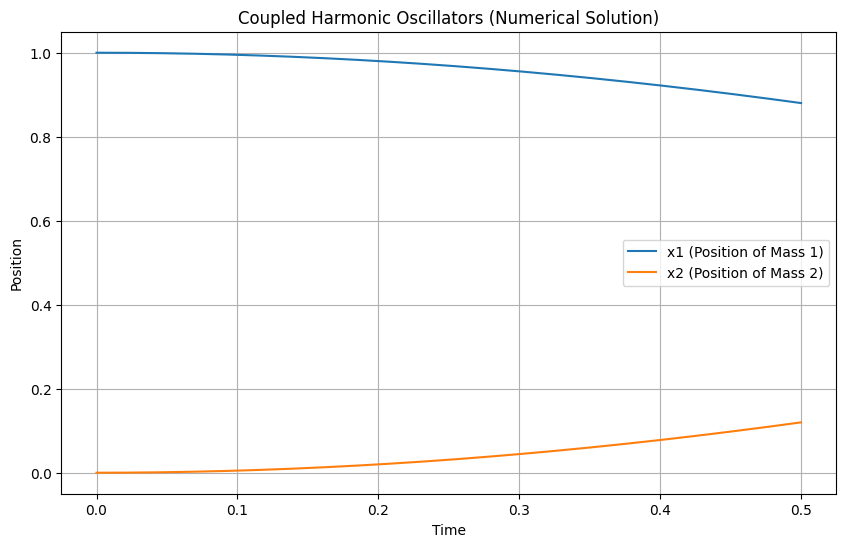

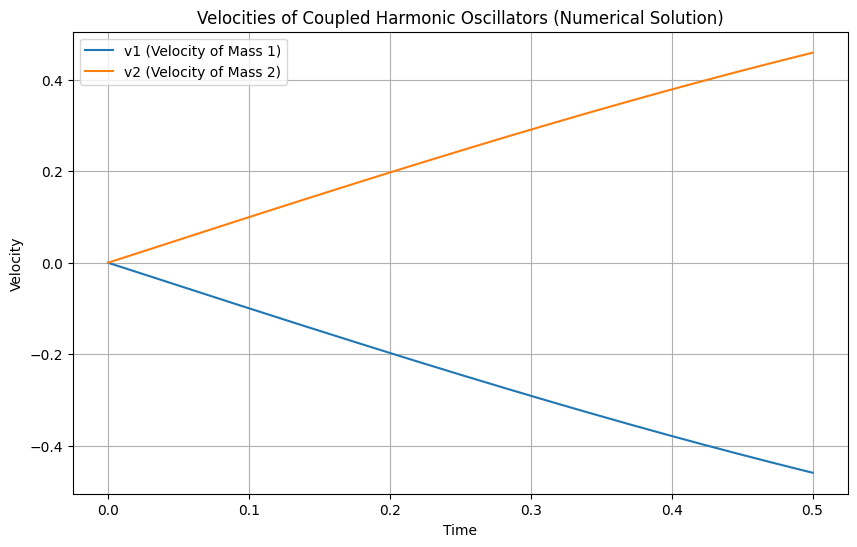

Final position of oscillator 1: 0.8801156094122277
Final position of oscillator 2: 0.11988439058777228
Final velocity of oscillator 1: -0.4593653935589795
Final velocity of oscillator 2: 0.4593653935589795


In [30]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Parameters
m1 = 1.0  # Mass of first oscillator
m2 = 1.0  # Mass of second oscillator
k1 = 0.0  # Spring constant for first oscillator
k2 = 0.0  # Spring constant for second oscillator
k12 = 1.0  # Coupling spring constant

# Define the system of differential equations
def equations(t, y):
    x1, v1, x2, v2 = y
    dx1dt = v1
    dv1dt = -(k1 + k12) / m1 * x1 + k12 / m1 * x2
    dx2dt = v2
    dv2dt = -(k2 + k12) / m2 * x2 + k12 / m2 * x1
    return [dx1dt, dv1dt, dx2dt, dv2dt]

# Initial conditions
x1_0 = 1.0  # Initial position of first oscillator
v1_0 = 0.0  # Initial velocity of first oscillator
x2_0 = 0.0  # Initial position of second oscillator
v2_0 = 0.0  # Initial velocity of second oscillator


initial_conditions = [x1_0, v1_0, x2_0, v2_0]

# Time span
t_span = (0, 0.5)
t_eval = np.linspace(t_span[0], t_span[1], 1000)

# Solve the system of differential equations
solution = solve_ivp(equations, t_span, initial_conditions, t_eval=t_eval, method='RK45')

# Extract the results
t = solution.t
x1 = solution.y[0]
v1 = solution.y[1]
x2 = solution.y[2]
v2 = solution.y[3]

# Plot position results
plt.figure(figsize=(10, 6))
plt.plot(t, x1, label='x1 (Position of Mass 1)')
plt.plot(t, x2, label='x2 (Position of Mass 2)')
plt.xlabel('Time')
plt.ylabel('Position')
plt.legend()
plt.title('Coupled Harmonic Oscillators (Numerical Solution)')
plt.grid()
plt.show()

# Plot velocity results
plt.figure(figsize=(10, 6))
plt.plot(t, v1, label='v1 (Velocity of Mass 1)')
plt.plot(t, v2, label='v2 (Velocity of Mass 2)')
plt.xlabel('Time')
plt.ylabel('Velocity')
plt.legend()
plt.title('Velocities of Coupled Harmonic Oscillators (Numerical Solution)')
plt.grid()
plt.show()


print("Final position of oscillator 1:", x1[-1])
print("Final position of oscillator 2:", x2[-1])
print("Final velocity of oscillator 1:", v1[-1])
print("Final velocity of oscillator 2:", v2[-1])


In [9]:
import classiq
from classiq import *
import numpy as np
from classiq.execution import ClassiqBackendPreferences, ClassiqSimulatorBackendNames, ExecutionPreferences


Execution_Prefs = ExecutionPreferences(
    num_shots=1,
    backend_preferences=ClassiqBackendPreferences(
        backend_name=ClassiqSimulatorBackendNames.SIMULATOR_STATEVECTOR
    ),
)


@qfunc 
def main(state:Output[QNum]):
    allocate(1,state)
    H(state)
    PHASE(np.pi, state)
    H(state)

qmod= create_model(main, execution_preferences=Execution_Prefs)
qprog=synthesize(qmod)
results = execute(qprog).result()
results



[TaggedExecutionDetails(value_type=<SavedResultValueType.ExecutionDetails: 'ExecutionDetails'>, name='result', value=ExecutionDetails(vendor_format_result={}, counts={'1': 1}, counts_lsb_right=True, parsed_states={'1': {'state': 1.0}}, histogram=None, output_qubits_map={'state': (0,)}, state_vector={'0': '(-1.8369701987210297e-16+0j)', '1': '(1.8369701987210297e-16+1j)'}, parsed_state_vector_states={'0': {'state': 0.0}, '1': {'state': 1.0}}, physical_qubits_map={'state': (0,)}, num_shots=1))]

In [15]:
parsed_state_vector= results[0].value.parsed_state_vector  # to get the phases
parsed_state_vector

[SimulatedState(state={'state': 1.0}, bitstring='1', amplitude=(1.8369701987210297e-16+1j)),
 SimulatedState(state={'state': 0.0}, bitstring='0', amplitude=(-1.8369701987210297e-16+0j))]

In [22]:
# Find the meausurement results of state in a dictionary format
state_amplitudes = sum_amplitudes_by_state(parsed_state_vector)
print(state_amplitudes)

# Normalize the final state
normalized_final_state = normalize_final_state(state_amplitudes, parsed_state_vector)
print(normalized_final_state)

# Simplify the final state by neglecting small terms
simplified_final_state = simplify_final_state(normalized_final_state)
print(simplified_final_state)

# Correct the normalization factor that comes from the normalization of initial state and transform the row vector to column vector
final_state = norm * simplified_final_state[..., None]
print("The final quantum state from quantum evolution", final_state)


{0: (-1.8369701987210297e-16+0j), 1: (1.8369701987210297e-16+1j)}
[ 1.8369702e-16+2.24963967e-32j -6.1232340e-17-1.00000000e+00j]
[0.+0.j 0.-1.j]
The final quantum state from quantum evolution [[0.+0.j]
 [0.-1.j]]
